# Introduction



In this notebook, we will 
- Learn how to use BoostedTrees Classifier for training and evaluating
- Explore how training can be speeded up for small datasets
- Will develop intuition for how some of the hyperparameters affect the performance of boosted trees.


In [1]:
# We will use some np and pandas for dealing with input data.
import numpy as np
import pandas as pd
# And of course, we need tensorflow
import tensorflow as tf

from distutils.version import StrictVersion

In [2]:
tf.__version__

'1.14.0'

# Load dataset
We will be using the titanic dataset, where the goal is to predict passenger survival given characteristiscs such as gender, age, class, etc.

In [3]:
tf.logging.set_verbosity(tf.logging.INFO)
tf.set_random_seed(123)

# Load dataset.
dftrain = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/train.csv')
dfeval = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/eval.csv')
y_train = dftrain.pop('survived')
y_eval = dfeval.pop('survived')

In [4]:
dftrain.head()

,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n
1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
2,female,26.0,0,0,7.9250,Third,unknown,Southampton,y
3,female,35.0,1,0,53.1000,First,C,Southampton,n
4,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y


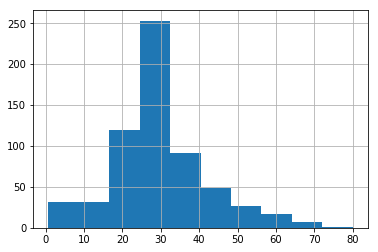

In [5]:
dftrain['age'].hist()

In [6]:
dftrain['embark_town'].value_counts()

Southampton    450
Cherbourg      123
Queenstown      53
unknown          1
Name: embark_town, dtype: int64

In [7]:
fcol = tf.feature_column
CATEGORICAL_COLUMNS = ['sex', 'n_siblings_spouses', 'parch', 'class', 'deck',
                       'embark_town', 'alone']
NUMERIC_COLUMNS = ['age', 'fare']

def one_hot_cat_column(feature_name, vocab):
  return fcol.indicator_column(
      fcol.categorical_column_with_vocabulary_list(feature_name,
                                                 vocab))
fc = []
for feature_name in CATEGORICAL_COLUMNS:
  # Need to one-hot encode categorical features.
  vocabulary = dftrain[feature_name].unique()
  fc.append(one_hot_cat_column(feature_name, vocabulary))

for feature_name in NUMERIC_COLUMNS:
  fc.append(fcol.numeric_column(feature_name,
                                dtype=tf.float32))

In [8]:
# Prepare the input fn. Use the entire dataset for a batch since this is such a small dataset.
def make_input_fn(X, y, n_epochs=None, do_batching=True):
    def input_fn():
        BATCH_SIZE = len(y)  # Use entire dataset.
        dataset = tf.data.Dataset.from_tensor_slices((X.to_dict(orient='list'), y))
        # For training, cycle thru dataset as many times as need (n_epochs=None).    
        dataset = dataset.repeat(n_epochs)  
        if do_batching:
            dataset = dataset.batch(BATCH_SIZE)
        return dataset
    return input_fn

# Training and Evaluating Classifiers

Exercise: Train a Boosted Trees model using tf.estimator. What are the best results you can get?

Train and evaluate the model. We will look at accuracy first.


In [9]:
TRAIN_SIZE = len(dftrain)
params = {
  'n_trees':10,
  'center_bias':False,
  'l2_regularization':1./TRAIN_SIZE # regularization is per instance, so if you are familiar with XGBoost, you need to divide these values by the num of examples per layer
}


# Training and evaluation input functions.
n_batches_per_layer = 1  # Use one batch, consisting of the entire dataset to build each layer in the tree.
DO_BATCHING = True

train_input_fn = make_input_fn(dftrain, y_train, n_epochs=None, do_batching=DO_BATCHING)
eval_input_fn = make_input_fn(dfeval, y_eval, n_epochs=1, do_batching=DO_BATCHING)
est = tf.estimator.BoostedTreesClassifier(fc, n_batches_per_layer, **params)

est.train(train_input_fn)

# Eval.
pd.Series(est.evaluate(eval_input_fn))

I0722 14:31:35.565665 139996009612736 estimator.py:1790] Using default config.
W0722 14:31:35.569427 139996009612736 estimator.py:1811] Using temporary folder as model directory: /tmp/tmpp04B2v
I0722 14:31:35.573219 139996009612736 estimator.py:209] Using config: {'_save_checkpoints_secs': 600, '_num_ps_replicas': 0, '_keep_checkpoint_max': 5, '_task_type': 'worker', '_global_id_in_cluster': 0, '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f5300ba1f90>, '_model_dir': '/tmp/tmpp04B2v', '_protocol': None, '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_service': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_tf_random_seed': None, '_save_summary_steps': 100, '_device_fn': None, '_experimental_distribute': None, '_num_worker_replicas': 1, '_task_id': 0, '_log_step_count_steps': 100, '_experimental_max_worker_delay_secs': No

accuracy                 0.806818
accuracy_baseline        0.625000
auc                      0.866330
auc_precision_recall     0.850316
average_loss             0.419913
global_step             60.000000
label/mean               0.375000
loss                     0.419913
precision                0.750000
prediction/mean          0.385222
recall                   0.727273
dtype: float64

Base model test data:

accuracy                 0.806818
accuracy_baseline        0.625000
auc                      0.866330
auc_precision_recall     0.850316
average_loss             0.419913
global_step             60.000000
label/mean               0.375000
loss                     0.419913
precision                0.750000
prediction/mean          0.385222
recall                   0.727273

Base model train data:
    
accuracy                 0.886762
accuracy_baseline        0.612440
auc                      0.946545
auc_precision_recall     0.934759
average_loss             0.300738
global_step             60.000000
label/mean               0.387560
loss                     0.300738
precision                0.887387
prediction/mean          0.387528
recall                   0.810700
dtype: float64    

In [10]:
pd.Series(est.evaluate(make_input_fn(dftrain, y_train, n_epochs=1, do_batching=DO_BATCHING)))

I0722 14:31:42.856827 139996009612736 estimator.py:1145] Calling model_fn.
W0722 14:31:43.761646 139996009612736 metrics_impl.py:804] Trapezoidal rule is known to produce incorrect PR-AUCs; please switch to "careful_interpolation" instead.
W0722 14:31:43.783691 139996009612736 metrics_impl.py:804] Trapezoidal rule is known to produce incorrect PR-AUCs; please switch to "careful_interpolation" instead.
I0722 14:31:43.805263 139996009612736 estimator.py:1147] Done calling model_fn.
I0722 14:31:43.825486 139996009612736 evaluation.py:255] Starting evaluation at 2019-07-22T14:31:43Z
I0722 14:31:43.935919 139996009612736 monitored_session.py:240] Graph was finalized.
I0722 14:31:43.938720 139996009612736 saver.py:1280] Restoring parameters from /tmp/tmpp04B2v/model.ckpt-60
I0722 14:31:44.034354 139996009612736 session_manager.py:500] Running local_init_op.
I0722 14:31:44.123128 139996009612736 session_manager.py:502] Done running local_init_op.
I0722 14:31:45.216234 139996009612736 evaluati

accuracy                 0.886762
accuracy_baseline        0.612440
auc                      0.946545
auc_precision_recall     0.934759
average_loss             0.300738
global_step             60.000000
label/mean               0.387560
loss                     0.300738
precision                0.887387
prediction/mean          0.387528
recall                   0.810700
dtype: float64

Exercise #2:  Can you get better performance out of the classifier? How do the results compare to using a DNN? Accuracy and AUC?

# Results

Let's understand how our model is performing.

I0722 14:31:45.312201 139996009612736 estimator.py:1145] Calling model_fn.
I0722 14:31:45.696373 139996009612736 estimator.py:1147] Done calling model_fn.
I0722 14:31:45.792782 139996009612736 monitored_session.py:240] Graph was finalized.
I0722 14:31:45.796041 139996009612736 saver.py:1280] Restoring parameters from /tmp/tmpp04B2v/model.ckpt-60
I0722 14:31:45.849188 139996009612736 session_manager.py:500] Running local_init_op.
I0722 14:31:45.868169 139996009612736 session_manager.py:502] Done running local_init_op.


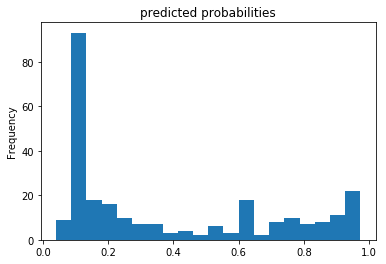

In [11]:
pred_dicts = list(est.predict(eval_input_fn))
probs = pd.Series([pred['probabilities'][1] for pred in pred_dicts])
y_preds = pd.Series([pred['class_ids'][0] for pred in pred_dicts])
probs.plot(kind='hist', bins=20, title='predicted probabilities');

**???** Why are the probabilities right skewed?

In [12]:
y_train.value_counts()

0    384
1    243
Name: survived, dtype: int64

Let's plot an ROC curve to understand model performance for various predicition probabilities.

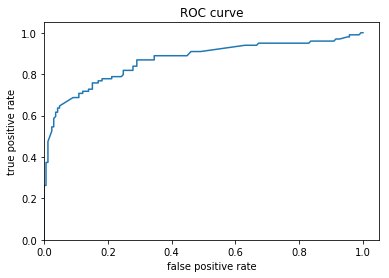

In [13]:
from sklearn.metrics import confusion_matrix, roc_curve
from matplotlib import pyplot as plt

fpr, tpr, _ = roc_curve(y_eval, probs)
plt.plot(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.xlim(0,)
plt.ylim(0,);

**???** What does true positive rate and false positive rate refer to for this dataset?

In [14]:
confusion_matrix(y_eval, y_preds)

array([[141,  24],
       [ 27,  72]])

Copyright 2019 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License

In [15]:
TRAIN_SIZE = len(dftrain)
params = {
  'n_trees':20,
  'center_bias':False,
  'max_depth' : 2,  
  'l2_regularization':1./TRAIN_SIZE # regularization is per instance, so if you are familiar with XGBoost, you need to divide these values by the num of examples per layer
}


# Training and evaluation input functions.
n_batches_per_layer = 1  # Use one batch, consisting of the entire dataset to build each layer in the tree.
DO_BATCHING = True

train_input_fn = make_input_fn(dftrain, y_train, n_epochs=None, do_batching=DO_BATCHING)
eval_input_fn = make_input_fn(dfeval, y_eval, n_epochs=1, do_batching=DO_BATCHING)
est = tf.estimator.BoostedTreesClassifier(fc, n_batches_per_layer, **params)

est.train(train_input_fn)

# Eval.
pd.Series(est.evaluate(eval_input_fn))

I0722 14:31:46.826551 139996009612736 estimator.py:1790] Using default config.
W0722 14:31:46.831798 139996009612736 estimator.py:1811] Using temporary folder as model directory: /tmp/tmpVl5Y1F
I0722 14:31:46.834060 139996009612736 estimator.py:209] Using config: {'_save_checkpoints_secs': 600, '_num_ps_replicas': 0, '_keep_checkpoint_max': 5, '_task_type': 'worker', '_global_id_in_cluster': 0, '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f52f2638990>, '_model_dir': '/tmp/tmpVl5Y1F', '_protocol': None, '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_service': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_tf_random_seed': None, '_save_summary_steps': 100, '_device_fn': None, '_experimental_distribute': None, '_num_worker_replicas': 1, '_task_id': 0, '_log_step_count_steps': 100, '_experimental_max_worker_delay_secs': No

accuracy                 0.742424
accuracy_baseline        0.625000
auc                      0.827518
auc_precision_recall     0.790713
average_loss             0.471008
global_step             40.000000
label/mean               0.375000
loss                     0.471008
precision                0.659794
prediction/mean          0.388908
recall                   0.646465
dtype: float64

In [44]:
TRAIN_SIZE = len(dftrain)
params = {
  'n_trees':100,
  'center_bias':False,
  'max_depth' : 2,  
  'l2_regularization':1./TRAIN_SIZE # regularization is per instance, so if you are familiar with XGBoost, you need to divide these values by the num of examples per layer
}


# Training and evaluation input functions.
n_batches_per_layer = 1  # Use one batch, consisting of the entire dataset to build each layer in the tree.
DO_BATCHING = True

train_input_fn = make_input_fn(dftrain, y_train, n_epochs=None, do_batching=DO_BATCHING)
eval_input_fn = make_input_fn(dfeval, y_eval, n_epochs=1, do_batching=DO_BATCHING)
est = tf.estimator.BoostedTreesClassifier(fc, n_batches_per_layer, **params)

est.train(train_input_fn)

# Eval.
eval_results = pd.Series(est.evaluate(eval_input_fn))
train_results = pd.Series(est.evaluate(make_input_fn(dftrain, y_train, n_epochs=1, do_batching=DO_BATCHING)))
pd.DataFrame({'Train': train_results, 'Eval': eval_results})

I0722 14:54:49.847929 139996009612736 estimator.py:1790] Using default config.
W0722 14:54:49.850162 139996009612736 estimator.py:1811] Using temporary folder as model directory: /tmp/tmpBugC5R
I0722 14:54:49.851988 139996009612736 estimator.py:209] Using config: {'_save_checkpoints_secs': 600, '_num_ps_replicas': 0, '_keep_checkpoint_max': 5, '_task_type': 'worker', '_global_id_in_cluster': 0, '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f5300156fd0>, '_model_dir': '/tmp/tmpBugC5R', '_protocol': None, '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_service': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_tf_random_seed': None, '_save_summary_steps': 100, '_device_fn': None, '_experimental_distribute': None, '_num_worker_replicas': 1, '_task_id': 0, '_log_step_count_steps': 100, '_experimental_max_worker_delay_secs': No

,Eval,Train
accuracy,0.795455,0.861244
accuracy_baseline,0.625000,0.612440
auc,0.854454,0.907761
auc_precision_recall,0.829801,0.891782
average_loss,0.440519,0.363536
global_step,200.000000,200.000000
label/mean,0.375000,0.387560
loss,0.440519,0.363536
precision,0.722772,0.851351
prediction/mean,0.391465,0.387353


I0722 14:32:02.817251 139996009612736 estimator.py:1145] Calling model_fn.
I0722 14:32:02.989047 139996009612736 estimator.py:1147] Done calling model_fn.
I0722 14:32:03.085903 139996009612736 monitored_session.py:240] Graph was finalized.
I0722 14:32:03.088977 139996009612736 saver.py:1280] Restoring parameters from /tmp/tmpdtPYOt/model.ckpt-200
I0722 14:32:03.142786 139996009612736 session_manager.py:500] Running local_init_op.
I0722 14:32:03.163193 139996009612736 session_manager.py:502] Done running local_init_op.


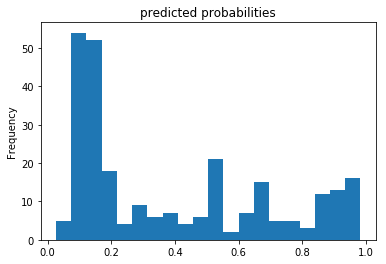

In [17]:
pred_dicts = list(est.predict(eval_input_fn))
probs = pd.Series([pred['probabilities'][1] for pred in pred_dicts])
y_preds = pd.Series([pred['class_ids'][0] for pred in pred_dicts])
probs.plot(kind='hist', bins=20, title='predicted probabilities');

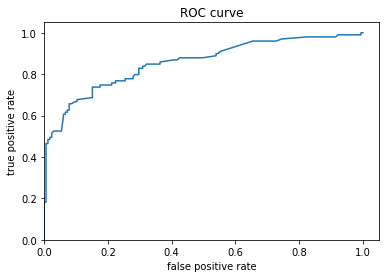

In [18]:
fpr, tpr, _ = roc_curve(y_eval, probs)
plt.plot(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.xlim(0,)
plt.ylim(0,);

In [43]:
TRAIN_SIZE = len(dftrain)
params = {
  'n_trees':100,
  'max_depth' : 4,  
  'l2_regularization':1./TRAIN_SIZE, # regularization is per instance, so if you are familiar with XGBoost, you need to divide these values by the num of examples per layer
  'center_bias':False
}


# Training and evaluation input functions.
n_batches_per_layer = 1  # Use one batch, consisting of the entire dataset to build each layer in the tree.
DO_BATCHING = True

train_input_fn = make_input_fn(dftrain, y_train, n_epochs=None, do_batching=DO_BATCHING)
eval_input_fn = make_input_fn(dfeval, y_eval, n_epochs=1, do_batching=DO_BATCHING)
est = tf.estimator.BoostedTreesClassifier(fc, n_batches_per_layer, **params)

est.train(train_input_fn)

# Eval.
eval_results = pd.Series(est.evaluate(eval_input_fn))
train_results = pd.Series(est.evaluate(make_input_fn(dftrain, y_train, n_epochs=1, do_batching=DO_BATCHING)))
pd.DataFrame({'Train': train_results, 'Eval': eval_results})

I0722 14:53:04.360652 139996009612736 estimator.py:1790] Using default config.
W0722 14:53:04.365277 139996009612736 estimator.py:1811] Using temporary folder as model directory: /tmp/tmpx8TvCk
I0722 14:53:04.367219 139996009612736 estimator.py:209] Using config: {'_save_checkpoints_secs': 600, '_num_ps_replicas': 0, '_keep_checkpoint_max': 5, '_task_type': 'worker', '_global_id_in_cluster': 0, '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f52d1079bd0>, '_model_dir': '/tmp/tmpx8TvCk', '_protocol': None, '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_service': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_tf_random_seed': None, '_save_summary_steps': 100, '_device_fn': None, '_experimental_distribute': None, '_num_worker_replicas': 1, '_task_id': 0, '_log_step_count_steps': 100, '_experimental_max_worker_delay_secs': No

,Eval,Train
accuracy,0.821970,0.929825
accuracy_baseline,0.625000,0.612440
auc,0.860728,0.977822
auc_precision_recall,0.841869,0.971178
average_loss,0.428351,0.212273
global_step,400.000000,400.000000
label/mean,0.375000,0.387560
loss,0.428351,0.212273
precision,0.788889,0.934498
prediction/mean,0.383113,0.387070


In [25]:
est.experimental_feature_importances(normalize=True)

OrderedDict([('fare', 0.26067275559390357),
             ('sex', 0.2588596429820049),
             ('age', 0.22032058456504294),
             ('class', 0.09387235138153006),
             ('deck', 0.06469387142703197),
             ('embark_town', 0.039039260093583224),
             ('n_siblings_spouses', 0.027248649603590226),
             ('parch', 0.01888522767709404),
             ('alone', 0.01640765667621903)])

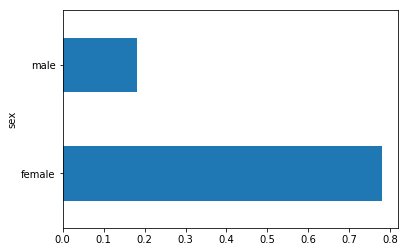

In [32]:
merged = pd.concat([dftrain, y_train], axis=1)
merged.groupby('sex').survived.mean().plot(kind='barh')

In [33]:
merged['fare'].corr(merged['survived'])

0.25247837359427955

In [34]:
merged['age'].corr(merged['survived'])

-0.03314476842861428

In [35]:
df_survived = merged[merged['survived'] == 1]
df_died = merged[merged['survived'] == 0]

/usr/local/lib/python2.7/dist-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


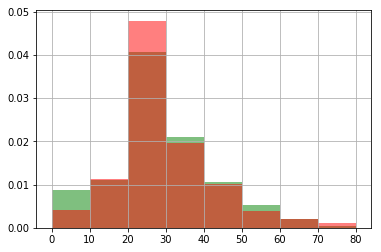

In [40]:
bins = [0,10,20,30,40,50,60,70,80]
df_survived['age'].hist(alpha=0.5, color='green', bins=bins, normed=True)
df_died['age'].hist(alpha=0.5, color='red', bins=bins, normed=True)
plt.show()

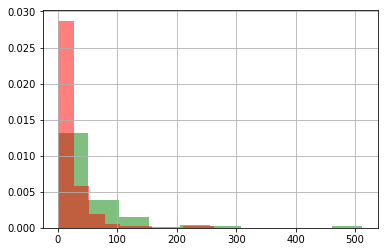

In [41]:
df_survived['fare'].hist(alpha=0.5, color='green', normed=True)
df_died['fare'].hist(alpha=0.5, color='red', normed=True)
plt.show()

In [26]:
pd.Series(est.evaluate(make_input_fn(dftrain, y_train, n_epochs=1, do_batching=DO_BATCHING)))

I0722 14:41:29.885025 139996009612736 estimator.py:1145] Calling model_fn.
W0722 14:41:30.820516 139996009612736 metrics_impl.py:804] Trapezoidal rule is known to produce incorrect PR-AUCs; please switch to "careful_interpolation" instead.
W0722 14:41:30.841654 139996009612736 metrics_impl.py:804] Trapezoidal rule is known to produce incorrect PR-AUCs; please switch to "careful_interpolation" instead.
I0722 14:41:30.864413 139996009612736 estimator.py:1147] Done calling model_fn.
I0722 14:41:30.885152 139996009612736 evaluation.py:255] Starting evaluation at 2019-07-22T14:41:30Z
I0722 14:41:30.994900 139996009612736 monitored_session.py:240] Graph was finalized.
I0722 14:41:30.998346 139996009612736 saver.py:1280] Restoring parameters from /tmp/tmpi7fyO5/model.ckpt-400
I0722 14:41:31.093931 139996009612736 session_manager.py:500] Running local_init_op.
I0722 14:41:31.177222 139996009612736 session_manager.py:502] Done running local_init_op.
I0722 14:41:32.410644 139996009612736 evaluat

accuracy                  0.929825
accuracy_baseline         0.612440
auc                       0.977822
auc_precision_recall      0.971178
average_loss              0.212273
global_step             400.000000
label/mean                0.387560
loss                      0.212273
precision                 0.934498
prediction/mean           0.387070
recall                    0.880658
dtype: float64

### Compare performance to a DNN

In [23]:
TRAIN_SIZE = len(dftrain)

# Training and evaluation input functions.
n_batches_per_layer = 1  # Use one batch, consisting of the entire dataset to build each layer in the tree.
DO_BATCHING = True

train_input_fn = make_input_fn(dftrain, y_train, n_epochs=None, do_batching=DO_BATCHING)
eval_input_fn = make_input_fn(dfeval, y_eval, n_epochs=1, do_batching=DO_BATCHING)
est = tf.estimator.DNNClassifier(feature_columns = fc, hidden_units = [10, 10])

est.train(train_input_fn, max_steps=1000)

# Eval.
pd.Series(est.evaluate(eval_input_fn))

I0722 14:40:28.443454 139996009612736 estimator.py:1790] Using default config.
W0722 14:40:28.445431 139996009612736 estimator.py:1811] Using temporary folder as model directory: /tmp/tmpxxRWR5
I0722 14:40:28.447161 139996009612736 estimator.py:209] Using config: {'_save_checkpoints_secs': 600, '_num_ps_replicas': 0, '_keep_checkpoint_max': 5, '_task_type': 'worker', '_global_id_in_cluster': 0, '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f52f2334a50>, '_model_dir': '/tmp/tmpxxRWR5', '_protocol': None, '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_service': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_tf_random_seed': None, '_save_summary_steps': 100, '_device_fn': None, '_experimental_distribute': None, '_num_worker_replicas': 1, '_task_id': 0, '_log_step_count_steps': 100, '_experimental_max_worker_delay_secs': No

accuracy                   0.799242
accuracy_baseline          0.625000
auc                        0.815152
auc_precision_recall       0.761187
average_loss               0.546284
global_step             1000.000000
label/mean                 0.375000
loss                     144.219025
precision                  0.721154
prediction/mean            0.420258
recall                     0.757576
dtype: float64

In [49]:
TRAIN_SIZE = len(dftrain)
params = {
  'n_trees':20,
  'center_bias':False,
  'max_depth' : 6,  
  'l2_regularization':1./TRAIN_SIZE # regularization is per instance, so if you are familiar with XGBoost, you need to divide these values by the num of examples per layer
}


# Training and evaluation input functions.
n_batches_per_layer = 1  # Use one batch, consisting of the entire dataset to build each layer in the tree.
DO_BATCHING = True

train_input_fn = make_input_fn(dftrain, y_train, n_epochs=None, do_batching=DO_BATCHING)
eval_input_fn = make_input_fn(dfeval, y_eval, n_epochs=1, do_batching=DO_BATCHING)
est = tf.estimator.BoostedTreesClassifier(fc, n_batches_per_layer, **params)

est.train(train_input_fn)

# Eval.
eval_results = pd.Series(est.evaluate(eval_input_fn))
train_results = pd.Series(est.evaluate(make_input_fn(dftrain, y_train, n_epochs=1, do_batching=DO_BATCHING)))
pd.DataFrame({'Train': train_results, 'Eval': eval_results})

I0722 14:58:07.137808 139996009612736 estimator.py:1790] Using default config.
W0722 14:58:07.140451 139996009612736 estimator.py:1811] Using temporary folder as model directory: /tmp/tmpn4dMqF
I0722 14:58:07.142752 139996009612736 estimator.py:209] Using config: {'_save_checkpoints_secs': 600, '_num_ps_replicas': 0, '_keep_checkpoint_max': 5, '_task_type': 'worker', '_global_id_in_cluster': 0, '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f52f210ee10>, '_model_dir': '/tmp/tmpn4dMqF', '_protocol': None, '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_service': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_tf_random_seed': None, '_save_summary_steps': 100, '_device_fn': None, '_experimental_distribute': None, '_num_worker_replicas': 1, '_task_id': 0, '_log_step_count_steps': 100, '_experimental_max_worker_delay_secs': No

,Eval,Train
accuracy,0.814394,0.926635
accuracy_baseline,0.625000,0.612440
auc,0.873278,0.973021
auc_precision_recall,0.855603,0.966619
average_loss,0.414891,0.233438
global_step,120.000000,120.000000
label/mean,0.375000,0.387560
loss,0.414891,0.233438
precision,0.765957,0.941704
prediction/mean,0.386309,0.387533


In [52]:
TRAIN_SIZE = len(dftrain)
params = {
  'n_trees':50,
  'center_bias':False,
  'max_depth' : 6,  
  'l2_regularization':1./TRAIN_SIZE # regularization is per instance, so if you are familiar with XGBoost, you need to divide these values by the num of examples per layer
}


# Training and evaluation input functions.
n_batches_per_layer = 1  # Use one batch, consisting of the entire dataset to build each layer in the tree.
DO_BATCHING = True

train_input_fn = make_input_fn(dftrain, y_train, n_epochs=None, do_batching=DO_BATCHING)
eval_input_fn = make_input_fn(dfeval, y_eval, n_epochs=1, do_batching=DO_BATCHING)
est = tf.estimator.BoostedTreesClassifier(fc, n_batches_per_layer, **params)

est.train(train_input_fn)

# Eval.
eval_results = pd.Series(est.evaluate(eval_input_fn))
train_results = pd.Series(est.evaluate(make_input_fn(dftrain, y_train, n_epochs=1, do_batching=DO_BATCHING)))
pd.DataFrame({'Train': train_results, 'Eval': eval_results})

I0722 15:00:28.922301 139996009612736 estimator.py:1790] Using default config.
W0722 15:00:28.925719 139996009612736 estimator.py:1811] Using temporary folder as model directory: /tmp/tmpWvOKrA
I0722 15:00:28.928303 139996009612736 estimator.py:209] Using config: {'_save_checkpoints_secs': 600, '_num_ps_replicas': 0, '_keep_checkpoint_max': 5, '_task_type': 'worker', '_global_id_in_cluster': 0, '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f530018d1d0>, '_model_dir': '/tmp/tmpWvOKrA', '_protocol': None, '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_service': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_tf_random_seed': None, '_save_summary_steps': 100, '_device_fn': None, '_experimental_distribute': None, '_num_worker_replicas': 1, '_task_id': 0, '_log_step_count_steps': 100, '_experimental_max_worker_delay_secs': No

,Eval,Train
accuracy,0.829545,0.966507
accuracy_baseline,0.625000,0.612440
auc,0.858280,0.992070
auc_precision_recall,0.843772,0.989251
average_loss,0.445165,0.149227
global_step,300.000000,300.000000
label/mean,0.375000,0.387560
loss,0.445165,0.149227
precision,0.787234,0.974359
prediction/mean,0.387926,0.387635


In [50]:
import pandas_profiling

/usr/local/lib/python2.7/dist-packages/pandas_profiling/plot.py:15: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/usr/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/usr/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python2.7/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelapp.py", line 499, in start
    self.io_loop.start()
  File "/usr/local/lib/python2.7/dist-pa

In [51]:
pandas_profiling.ProfileReport(dftrain)

Number of variables,9
Number of observations,627
Total Missing (%),0.0%
Total size in memory,44.2 KiB
Average record size in memory,72.0 B
Numeric,4
Categorical,5
Boolean,0
Date,0
Text (Unique),0
Rejected,0


I0722 15:00:52.677264 139996009612736 estimator.py:1145] Calling model_fn.
I0722 15:00:53.077069 139996009612736 estimator.py:1147] Done calling model_fn.
I0722 15:00:53.176479 139996009612736 monitored_session.py:240] Graph was finalized.
I0722 15:00:53.180054 139996009612736 saver.py:1280] Restoring parameters from /tmp/tmpWvOKrA/model.ckpt-300
I0722 15:00:53.254004 139996009612736 session_manager.py:500] Running local_init_op.
I0722 15:00:53.276581 139996009612736 session_manager.py:502] Done running local_init_op.


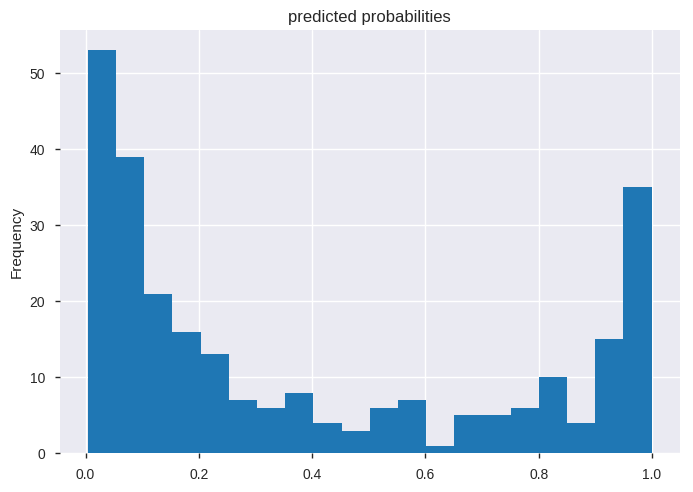

In [53]:
pred_dicts = list(est.predict(eval_input_fn))
probs = pd.Series([pred['probabilities'][1] for pred in pred_dicts])
y_preds = pd.Series([pred['class_ids'][0] for pred in pred_dicts])
probs.plot(kind='hist', bins=20, title='predicted probabilities');

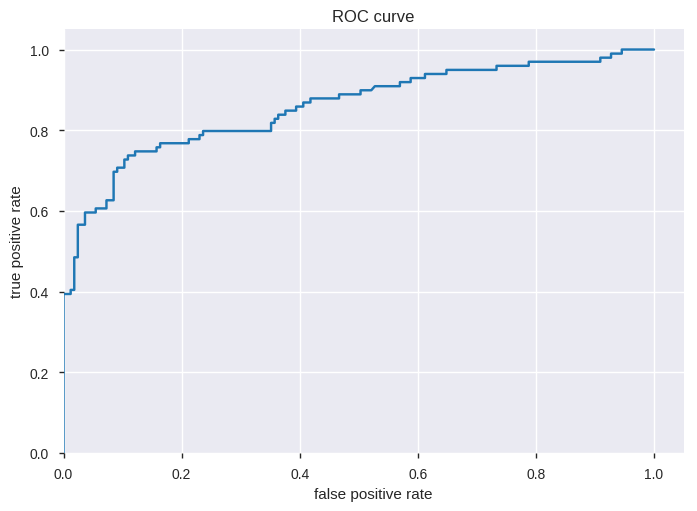

In [54]:
fpr, tpr, _ = roc_curve(y_eval, probs)
plt.plot(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.xlim(0,)
plt.ylim(0,);